# Filmception: AI-Powered Multilingual Movie Summary Translator and Genre Classifier

This notebook implements the **Filmception** project for the Spring 2025 Artificial Intelligence course, Department of Cyber Security. The project involves:
- **Step 1: Data Preprocessing and Cleaning**: Cleaning movie summaries and extracting genres from the CMU Movie Summary dataset.
- **Step 2: Text Translation and Audio Conversion**: Translating summaries into Arabic, Urdu, and Korean, and converting to audio.
- **Step 3: Movie Genre Prediction Model**: Building a multi-label classification model to predict movie genres.
- **Step 4: Interactive User Interface**: Creating a menu-based system with a bonus GUI for user interaction.
- **Step 5: Documentation and Report**: Generating a PDF report with visualizations.
- **Step 6: Demo Preparation**: Testing the system and preparing for Q&A.

**Dataset**: Uses cleaned files from `clean.ipynb` (`cleaned_plot_summaries.csv`, `cleaned_movie_metadata.csv`).

**Requirements**: Python 3.13.3, libraries: pandas, numpy, nltk, scikit-learn, transformers, googletrans, gtts, playsound, torch, scikit-multilearn, reportlab, matplotlib, seaborn, tkinter.

**Testing**: Each step includes tests to validate functionality, performance, and outputs.

## Step 1: Data Preprocessing and Cleaning

**Objective**: Load cleaned datasets, further preprocess summaries (lowercasing, stopword removal, lemmatization), extract genres, and create train-test splits.

**Tasks** (from project file, Page 2-3):
- Clean summaries (remove special characters, stopwords, numbers, punctuation; lowercase; tokenize; lemmatize).
- Extract genres from metadata.
- Create a final dataset with `movie_id`, `cleaned_summary`, `genres_list`.
- Perform train-test split.

**Marks**: Deep cleaning (10), tokenization/lemmatization (10), genre extraction (15), final dataset (10).

### 1.1 Setup and Installation

Install required libraries and download NLTK resources.

In [6]:
!pip install pandas numpy nltk scikit-learn transformers googletrans==3.1.0a0 gtts playsound torch scikit-multilearn reportlab matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cb26h\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cb26h\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 1.2 Test Setup

Verify library imports and NLTK resource availability.

In [2]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import transformers
import googletrans
import gtts
import playsound
import torch
import skmultilearn
import reportlab
import matplotlib
import seaborn

print("All libraries imported successfully.")
print("NLTK stopwords:", len(nltk.corpus.stopwords.words('english')), "words")
print("NLTK wordnet:", nltk.corpus.wordnet.synsets('test')[:1])

c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All libraries imported successfully.
NLTK stopwords: 198 words
NLTK wordnet: [Synset('trial.n.02')]


**Raw Dataset** download and then preprocessing to make it available in fromat of csv before it was in movie.metadata.tsv to cleaned_movie_metadata.csv and plot_summaries.txt to cleaned_plot_summaries.csv

In [3]:
# download it from  https://www.kaggle.com/datasets/msafi04/movies-genre-dataset-cmu-moviesummary
import pandas as pd
import re
import json
import ast

# Load plot summaries with error handling
def load_summaries(file_path):
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            # Print first 3 lines for debugging
            print("First 3 lines of plot_summaries.txt:")
            for i, line in enumerate(lines[:3]):
                print(f"Line {i+1}: {line.strip()}")
            for line in lines:
                parts = line.strip().split('\t', 1)  # Split on first tab
                if len(parts) == 2:
                    movie_id, summary = parts
                    movie_id = str(movie_id).strip()  # Ensure string and strip whitespace
                    data.append({'movie_id': movie_id, 'summary': summary})
                else:
                    print(f"Skipping malformed line: {line.strip()}")
        df = pd.DataFrame(data)
        df['movie_id'] = df['movie_id'].astype(str)  # Double-check type
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

# Load metadata with flexible genre parsing
def load_metadata(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t', header=None, on_bad_lines='skip')
        # Print first row for debugging
        print("First row of movie.metadata.tsv:")
        print(df.iloc[0].to_list())
        # Assume typical CMU structure: 9 columns
        expected_columns = ['movie_id', 'freebase_id', 'movie_name', 'release_date', 'box_office', 'runtime', 'languages', 'countries', 'genres']
        if len(df.columns) == len(expected_columns):
            df.columns = expected_columns
        else:
            print(f"Unexpected number of columns: {len(df.columns)}. Expected {len(expected_columns)}.")
            df.columns = [f"col_{i}" for i in range(len(df.columns))]
            genre_col = next((col for col in df.columns if 'genre' in col.lower()), None)
            if not genre_col:
                print("No genre column found. Using last column as genres.")
                genre_col = df.columns[-1]
            df = df[['col_0', genre_col]].rename(columns={'col_0': 'movie_id', genre_col: 'genres'})
        df['movie_id'] = df['movie_id'].astype(str).str.strip()  # Convert to string and strip whitespace
        return df[['movie_id', 'genres']]
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

# Clean summary text
def basic_clean_summary(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^\w\s.,!?]', '', text)  # Keep basic punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Parse genres with multiple format support
def parse_genres(genre_str):
    try:
        if isinstance(genre_str, str):
            if genre_str.startswith('{') or genre_str.startswith('['):
                parsed = ast.literal_eval(genre_str)
                if isinstance(parsed, dict):
                    return set(parsed.values())
                return set(parsed)
            else:
                return set(genre_str.split('|')) if '|' in genre_str else set(genre_str.split(','))
        return set()
    except Exception as e:
        print(f"Error parsing genres '{genre_str}': {e}")
        return set()

# Main cleaning process
try:
    # Load data
    summaries_df = load_summaries('plot_summaries.txt')
    metadata_df = load_metadata('movie.metadata.tsv')

    if summaries_df.empty or metadata_df.empty:
        raise ValueError("Failed to load one or both datasets.")

    # Clean summaries
    summaries_df['summary'] = summaries_df['summary'].apply(basic_clean_summary)
    summaries_df = summaries_df[summaries_df['summary'].str.len() > 0]

    # Clean metadata
    metadata_df['genres'] = metadata_df['genres'].apply(parse_genres)
    metadata_df = metadata_df[metadata_df['genres'].apply(len) > 0]
    metadata_df = metadata_df[['movie_id', 'genres']]

    # Debugging: Check types before merging
    print(f"Type of movie_id in summaries_df: {summaries_df['movie_id'].dtype}")
    print(f"Type of movie_id in metadata_df: {metadata_df['movie_id'].dtype}")

    # Merge and save cleaned data
    final_df = summaries_df.merge(metadata_df, on='movie_id', how='inner')
    final_df.to_csv('cleaned_plot_summaries.csv', index=False)
    metadata_df.to_csv('cleaned_movie_metadata.csv', index=False)

    print("Cleaned files saved: 'cleaned_plot_summaries.csv', 'cleaned_movie_metadata.csv'")
    print("Summaries Head:\n", summaries_df.head())
    print("Metadata Head:\n", metadata_df.head())
    print("Final Merged Head:\n", final_df.head())

except Exception as e:
    print(f"Error during cleaning: {e}")

First 3 lines of plot_summaries.txt:
Line 1: 23890098	Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.
Line 2: 31186339	The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual Hunger Games. The tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. In her first Reaping, 12-year-old Primrose Everdeen is chosen from District 12. Her older sister Katniss volunteers to take her place. Peeta Mellark, a baker's son who once gave Katniss bread when she was starving, is the other District 12 tribute. Katniss and Peeta are taken to the Capitol, accompanied by their frequently drunk mentor, past victor Haymitch Abernathy. He warns them about the "Career" tribut

### 1.3 Preprocessing Implementation

Load data, clean summaries, extract genres, and split dataset.

In [11]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import time

# Initialize NLTK resources
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def enhanced_clean_summary(text):
    """Clean and preprocess movie summary text.
    
    Args:
        text (str): Input summary text.
    
    Returns:
        str: Cleaned, lemmatized text with stopwords removed.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # If all tokens were stopwords, retain the first token
    if not tokens and text.strip():
        first_token = text.split()[0]
        tokens = [lemmatizer.lemmatize(first_token)]
    return ' '.join(tokens)

# Load cleaned data
start_time = time.time()
try:
    summaries_df = pd.read_csv('cleaned_plot_summaries.csv')
    metadata_df = pd.read_csv('cleaned_movie_metadata.csv')
except FileNotFoundError as e:
    print(f"Error: {e}")
    raise

# Further clean summaries
summaries_df['cleaned_summary'] = summaries_df['summary'].apply(enhanced_clean_summary)

# Parse genres
def parse_genres(x):
    try:
        return eval(x) if isinstance(x, str) and x.startswith('{') else set()
    except:
        return set()

metadata_df['genres'] = metadata_df['genres'].apply(parse_genres)
metadata_df['genres_list'] = metadata_df['genres'].apply(lambda x: list(x))

# Merge datasets
final_df = summaries_df[['movie_id', 'cleaned_summary']].merge(
    metadata_df[['movie_id', 'genres_list']],
    on='movie_id',
    how='inner'
)

# Remove rows with empty genres
final_df = final_df[final_df['genres_list'].apply(len) > 0]

# Save cleaned dataset
final_df.to_csv('final_cleaned_dataset.csv', index=False)
print(f"Final Dataset Head (Time: {time.time() - start_time:.2f}s):\n", final_df.head())

# Train-test split
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(final_df['genres_list'])
X = final_df[['movie_id', 'cleaned_summary']].values
y = np.array(y)

X_train, y_train, X_test, y_test = iterative_train_test_split(X, y, test_size=0.2)

train_df = pd.DataFrame({
    'movie_id': X_train[:, 0],
    'cleaned_summary': X_train[:, 1],
    'genres_list': [mlb.inverse_transform(y_train[i:i+1])[0] for i in range(y_train.shape[0])]
})
test_df = pd.DataFrame({
    'movie_id': X_test[:, 0],
    'cleaned_summary': X_test[:, 1],
    'genres_list': [mlb.inverse_transform(y_test[i:i+1])[0] for i in range(y_test.shape[0])]
})

# Save splits
train_df.to_csv('train_dataset.csv', index=False)
test_df.to_csv('test_dataset.csv', index=False)
print("Train-Test Split Completed. Classes:", mlb.classes_)
# Check for empty summaries or genres
print(final_df['cleaned_summary'].str.len().min())  # Should be > 0
print(final_df['genres_list'].apply(len).min())     # Should be > 0

Final Dataset Head (Time: 34.02s):
    movie_id                                    cleaned_summary  \
0  23890098  shlykov hardworking taxi driver lyosha saxopho...   
1  31186339  nation panem consists wealthy capitol twelve p...   
2  20663735  poovalli induchoodan sentenced six year prison...   
3   2231378  lemon drop kid new york city swindler illegall...   
4    595909  seventhday adventist church pastor michael cha...   

                                         genres_list  
0                              [World cinema, Drama]  
1  [Science Fiction, Action, Action/Adventure, Dr...  
2                [Action, Musical, Drama, Bollywood]  
3                         [Comedy, Screwball comedy]  
4  [Crime Fiction, World cinema, Drama, Courtroom...  
Train-Test Split Completed. Classes: ['Absurdism' 'Acid western' 'Action' 'Action Comedy' 'Action Thrillers'
 'Action/Adventure' 'Addiction Drama' 'Adult' 'Adventure'
 'Adventure Comedy' 'Airplanes and airports' 'Albino bias' 'Alien Film

: 

### 1.4 Test Preprocessing

Validate `enhanced_clean_summary`, dataset integrity, and split proportions.

In [4]:
# Test enhanced_clean_summary
test_cases = [
    "The Quick Brown Fox Jumps Over The Lazy Dog! 123",
    "",  # Empty string
    None,  # Non-string
    "the the is are"  # Stopwords
]
for test in test_cases:
    result = enhanced_clean_summary(test)
    print(f"Input: {test}\nOutput: {result}\n")

# Verify dataset integrity
assert 'movie_id' in final_df.columns, "Missing movie_id in final_df"
assert 'cleaned_summary' in final_df.columns, "Missing cleaned_summary in final_df"
assert 'genres_list' in final_df.columns, "Missing genres_list in final_df"
assert final_df['cleaned_summary'].str.len().min() > 0, "Empty summaries found"
print("Dataset integrity checks passed.")

# Verify split proportions
total = len(final_df)
train_size = len(train_df)
test_size = len(test_df)
print(f"Total: {total}, Train: {train_size} ({train_size/total:.2%}), Test: {test_size} ({test_size/total:.2%})")
assert abs(train_size/total - 0.8) < 0.05, "Train split not ~80%"
assert abs(test_size/total - 0.2) < 0.05, "Test split not ~20%"

# Sample output
print("Sample Train Row:\n", train_df.iloc[0])
print("Sample Test Row:\n", test_df.iloc[0])

Input: The Quick Brown Fox Jumps Over The Lazy Dog! 123
Output: quick brown fox jump lazy dog

Input: 
Output: 

Input: None
Output: 

Input: the the is are
Output: the

Dataset integrity checks passed.
Total: 41796, Train: 33614 (80.42%), Test: 8182 (19.58%)
Sample Train Row:
 movie_id                                                    31186339
cleaned_summary    nation panem consists wealthy capitol twelve p...
genres_list        (Action, Action/Adventure, Drama, Science Fict...
Name: 0, dtype: object
Sample Test Row:
 movie_id                                                    23890098
cleaned_summary    shlykov hardworking taxi driver lyosha saxopho...
genres_list                                    (Drama, World cinema)
Name: 0, dtype: object


## Step 2: Text Translation and Audio Conversion

**Objective**: Translate 50 summaries into Arabic, Urdu, and Korean, convert to audio, and store for playback.

**Tasks** (from project file, Page 3):
- Translate at least 50 summaries into three languages.
- Convert translated summaries to audio using TTS.
- Store audio files and provide playback options.

**Marks**: Accurate translation (20), audio conversion (20), storage/playback (10).

In [5]:
# Import the enhanced components
from audio_converter import AudioConverter
from translation_service import TranslationService
from batch_processor import batch_translate_and_convert


# For genre prediction functionality (assuming you have this file)
from genre_predictor import GenrePredictor
import pandas as pd
import os

# Try to load the dataset from your existing files in order of preference
try:
    # First try to load the final cleaned dataset
    if os.path.exists('final_cleaned_dataset.csv'):
        final_df = pd.read_csv('final_cleaned_dataset.csv')
        print(f"Loaded final_cleaned_dataset.csv with {len(final_df)} entries")
    
    # If not found, try train dataset
    elif os.path.exists('train_dataset.csv'):
        final_df = pd.read_csv('train_dataset.csv')
        print(f"Loaded train_dataset.csv with {len(final_df)} entries")
    
    # If not found, try cleaned plot summaries
    elif os.path.exists('cleaned_plot_summaries.csv'):
        final_df = pd.read_csv('cleaned_plot_summaries.csv')
        # Rename summary column if needed
        if 'summary' in final_df.columns and 'cleaned_summary' not in final_df.columns:
            final_df['cleaned_summary'] = final_df['summary']
        print(f"Loaded cleaned_plot_summaries.csv with {len(final_df)} entries")
    
    # If none of the above worked, create a sample dataset
    else:
        raise FileNotFoundError("No existing dataset found")
        
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Creating sample dataset instead")
    
    # Create a sample dataset
    final_df = pd.DataFrame({
        'movie_id': range(1, 11),
        'cleaned_summary': [
            "detective investigate murder small town",
            "family move haunt house",
            "superhero team save world alien invasion",
            "young wizard discover magical power fight evil",
            "group friend go road trip across country",
            "scientist create time machine accidentally change history",
            "spy try prevent global terrorist attack",
            "robot develop human emotion try live among people",
            "two enemy fall love war",
            "astronaut get strand alien planet"
        ]
    })

# Make sure we have the cleaned_summary column
if 'cleaned_summary' not in final_df.columns:
    print("Error: Dataset doesn't have a 'cleaned_summary' column")
    if 'summary' in final_df.columns:
        print("Converting 'summary' column to 'cleaned_summary'")
        final_df['cleaned_summary'] = final_df['summary']

# Process up to 50 summaries (or less if the dataset is smaller)
num_samples = min(50, len(final_df))
print(f"Processing {num_samples} summaries")

# Run batch processing
translations_df = batch_translate_and_convert(
    final_df,
    num_samples=num_samples,
    languages=['en', 'ar', 'ur', 'ko'],
    cache_file='translation_cache.json',
    max_workers=4,
    output_dir='audio_summaries'
)

print(f"Processed {len(translations_df)} summaries")
print(f"Audio files are in the 'audio_summaries' directory")

# Create adapter classes for compatibility with improved GUI
class TranslationAdapter:
    def __init__(self):
        self.service = TranslationService(cache_file='translation_cache.json')
    
    def translate(self, text, target_lang):
        return self.service.translate(text, target_lang)
    
    def get_supported_languages(self):
        return {
            'en': 'English',
            'ar': 'Arabic',
            'ur': 'Urdu',
            'ko': 'Korean',
            'fr': 'French',
            'es': 'Spanish',
            'de': 'German'
        }

class AudioConverterAdapter:
    def __init__(self):
        self.converter = AudioConverter(output_dir='audio_summaries')
    
    def create_audio(self, text, lang, output_file=None):
        success = self.converter.create_audio(text, lang, output_file)
        return success, output_file if success else None
    
    def play_audio(self, audio_file):
        return self.converter.play_audio(audio_file)

class PredictorAdapter:
    def __init__(self):
        self.predictor = GenrePredictor(output_dir="models")
        self.vectorizer = self.predictor.vectorizer
        self.model = self.predictor.model
        self.mlb = self.predictor.mlb
    
    def predict(self, text):
        return self.predictor.predict(text)
    
# Initialize components
translator = TranslationService(cache_file='translation_cache.json')
audio_converter = AudioConverter(output_dir='audio_summaries')
predictor = GenrePredictor(output_dir="models")

# Example usage
summary = "This is a test movie summary about a detective solving a crime."

# Translate
translated = translator.translate(summary, 'fr')
print(f"Translated: {translated}")

# Create audio
success, audio_file = audio_converter.create_audio(translated, 'fr')
if success:
    print(f"Audio created: {audio_file}")
    audio_converter.play_audio(audio_file)


# Batch processing example
if 'final_df' in globals():
    translations_df = batch_translate_and_convert(
        final_df, 
        num_samples=10, 
        languages=['en', 'fr', 'es'],
        max_workers=4,
        output_dir='audio_output'
    )

Loaded final_cleaned_dataset.csv with 41796 entries
Processing 50 summaries
Starting batch translation of 50 summaries to 4 languages...
Using deep_translator for translations (recommended)
Loaded 11 cached translations
Processing 1/50: Movie 23890098
Processing 2/50: Movie 31186339
Processing 3/50: Movie 20663735
Processing 4/50: Movie 2231378
Processing 5/50: Movie 595909
Processing 6/50: Movie 5272176
Processing 7/50: Movie 1952976
Processing 8/50: Movie 24225279
Processing 9/50: Movie 2462689
Processing 10/50: Movie 20532852
Processing 11/50: Movie 15401493
Processing 12/50: Movie 18188932
Processing 13/50: Movie 2940516
Processing 14/50: Movie 1335380
Processing 15/50: Movie 1480747
Processing 16/50: Movie 24448645
Processing 17/50: Movie 15072401
Processing 18/50: Movie 4018288
Processing 19/50: Movie 4596602
Processing 20/50: Movie 15224586
Processing 21/50: Movie 15585766
Processing 22/50: Movie 1760737
Processing 23/50: Movie 29062594
Processing 24/50: Movie 29326153
Processin

Error predicting genres: [Errno 2] No such file or directory: 'models\\tfidf_vectorizer.pkl'


Predicted genres: []
Starting batch translation of 10 summaries to 3 languages...
Using deep_translator for translations (recommended)
Loaded 148 cached translations
Processing 1/10: Movie 23890098
Processing 2/10: Movie 31186339
Processing 3/10: Movie 20663735
Processing 4/10: Movie 2231378
Processing 5/10: Movie 595909
Processing 6/10: Movie 5272176
Processing 7/10: Movie 1952976
Processing 8/10: Movie 24225279
Processing 9/10: Movie 2462689
Processing 10/10: Movie 20532852
Translations completed in 26.20s
Translations saved to audio_output\translated_summaries.csv
Processing 30 audio tasks using 4 workers...
Prepared text for 23890098 (en): shlykov hardworking taxi driver lyosha saxophonist develop bizarre lovehate relationship despite prejudice realize arent different.
Prepared text for 23890098 (fr): Le chauffeur de taxi travailleur de Shlykov Lyosha saxophoniste développe une relation bizarre sur l'amour malgré les préjugés, réalisez, n'est pas différent.
Prepared text for 238900

### 2.1 Test Translation and Audio

Validate translation accuracy, audio file creation, and playback.

In [2]:
import os
import random
from IPython.display import Audio, display
import time

audio_dir = 'audio_summaries'
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.mp3')]

# Find all unique languages in the filenames
languages = set()
for file in audio_files:
    parts = file.replace('.mp3', '').split('_')
    if len(parts) >= 2:
        lang = parts[-1]
        languages.add(lang)

for lang in sorted(languages):
    lang_files = [f for f in audio_files if f.endswith(f'_{lang}.mp3')]
    if not lang_files:
        print(f"No audio files for language '{lang}'.")
        continue
    file = random.choice(lang_files)
    print(f"\n--- Testing 1 sample for language: {lang} ---")
    print(f"Testing audio file: {file}")
    audio_path = os.path.join(audio_dir, file)


    display(Audio(audio_path))
    time.sleep(10)  # Wait 10 seconds before moving to the next language
    input("Press Enter to continue to the next language...")


--- Testing 1 sample for language: ar ---
Testing audio file: 20532852_ar.mp3



--- Testing 1 sample for language: en ---
Testing audio file: 595909_en.mp3



--- Testing 1 sample for language: fr ---
Testing audio file: audio_cfb27d74_fr.mp3



--- Testing 1 sample for language: ko ---
Testing audio file: 33269085_ko.mp3



--- Testing 1 sample for language: ur ---
Testing audio file: 29326153_ur.mp3


KeyboardInterrupt: 

## Step 3: Movie Genre Prediction Model

**Objective**: Build and evaluate two models: Logistic Regression with TF-IDF and a BERT-based neural network.

**Tasks** (from project file, Page 3-4):
- Develop a multi-label classification model.
- Extract features (TF-IDF or BERT embeddings).
- Evaluate with accuracy, precision, recall, F1-score, and confusion matrices.

**Marks**: Model selection (25), feature extraction (20), multi-label handling (20), train-test split (5), metrics (20), confusion matrix (10).

In [ ]:
#!/usr/bin/env python3
"""
genre_classifier.py

Parent‐genre multi-label classifier for CMU Movie Summaries
with enhanced TF-IDF features and per-genre threshold tuning.
"""

import re
import ast
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm, trange

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score

# ─── 1. Parent‐genre keyword map ──────────────────────────────────────────────────
PARENT_KEYWORDS = {
    "Action":          ["action"],
    "Adventure":       ["adventure"],
    "Animation":       ["animation"],
    "Comedy":          ["comedy", "comic"],
    "Crime":           ["crime"],
    "Documentary":     ["documentary"],
    "Drama":           ["drama", "black-and-white"],
    "Family":          ["family"],
    "Fantasy":         ["fantasy"],
    "Historical":      ["historical", "history"],
    "Horror":          ["horror", "slasher"],
    "Mystery":         ["mystery"],
    "Musical":         ["musical"],
    "Romance":         ["romanc", "romantic", "lgbt", "sexual fantasy"],
    "Science Fiction": ["science fiction", "sci-fi", "scifi"],
    "Thriller":        ["thriller"],
    "Western":         ["western"],
    "Short Film":      ["short film"],
}

# ─── 2. Load & merge data ─────────────────────────────────────────────────────────
def load_data(plots_path: str, meta_path: str) -> pd.DataFrame:
    print("→ Loading plot_summaries…")
    plots = pd.read_csv(
        plots_path, sep='\t', header=None,
        names=['wiki_movie_id','summary'],
        usecols=[0,1], quoting=3, engine='python'
    )
    print("→ Loading movie.metadata…")
    cols = [
        'wiki_movie_id','freebase_id','movie_name','release_date',
        'box_office','runtime','languages','countries','genres'
    ]
    meta = pd.read_csv(
        meta_path, sep='\t', header=None,
        names=cols, usecols=['wiki_movie_id','genres'],
        quoting=3, engine='python'
    )
    return pd.merge(plots, meta, on='wiki_movie_id')

# ─── 3. Clean text ────────────────────────────────────────────────────────────────
def clean_text(text: str, lemmatizer, stop_words) -> str:
    txt = re.sub(r'[^a-zA-Z\s]', ' ', text).lower()
    tokens = nltk.word_tokenize(txt)
    filtered = [t for t in tokens if t not in stop_words and len(t) > 1]
    return ' '.join(lemmatizer.lemmatize(t) for t in filtered)

# ─── 4. Parse & map genres ────────────────────────────────────────────────────────
def parse_and_map_genres(raw: str):
    """
    raw is Freebase‐style JSON:
      '{"\\/m\\/07s9rl0":"Drama",…}'
    Extract values, match against PARENT_KEYWORDS, dedupe.
    """
    try:
        d = ast.literal_eval(raw)
        vals = d.values()
    except:
        return []
    mapped = set()
    for v in vals:
        vl = v.lower()
        for parent, keywords in PARENT_KEYWORDS.items():
            for kw in keywords:
                if kw in vl:
                    mapped.add(parent)
                    break
    return list(mapped)

# ─── 5. Preprocessing: cleaning + mapping ─────────────────────────────────────────
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tqdm.pandas(desc="Cleaning summaries")
    df['clean_summary'] = df['summary']\
        .progress_apply(lambda t: clean_text(t, lemmatizer, stop_words))
    df['genre_list'] = df['genres'].apply(parse_and_map_genres)
    return df

# ─── 6. Train, tune thresholds, evaluate ──────────────────────────────────────────
def train_and_evaluate(df: pd.DataFrame):
    X = df['clean_summary']
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['genre_list'])
    classes = mlb.classes_
    print(f"→ Parent genres: {list(classes)}")

    # split: 64% train, 16% val, 20% test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, random_state=42
    )

    # richer TF-IDF
    print("→ Vectorizing text (TF-IDF)…")
    vect = TfidfVectorizer(
        max_features=20_000,
        ngram_range=(1,3),
        min_df=2
    )
    Xtr = vect.fit_transform(X_train)
    Xvl = vect.transform(X_val)
    Xte = vect.transform(X_test)

    # One-vs-rest with balanced weighting
    base_clf = LogisticRegression(
        solver='liblinear',
        class_weight='balanced',
        max_iter=200
    )
    genre = OneVsRestClassifier(base_clf, n_jobs=-1)

    print("→ Fitting classifier…")
    genre.fit(Xtr, y_train)

    # get validation probs and tune per-label thresholds
    print("→ Tuning thresholds on validation set…")
    probs_val = genre.predict_proba(Xvl)
    n_labels = len(classes)
    thresholds = np.zeros(n_labels)
    for i in trange(n_labels, desc="Thresh"):
        yv = y_val[:, i]
        pv = probs_val[:, i]
        # skip if no positives in val
        if yv.sum() == 0:
            thresholds[i] = 0.5
            continue
        best_thr, best_f1 = 0.5, 0.0
        for thr in np.arange(0.1, 0.9, 0.05):
            f1 = f1_score(yv, (pv >= thr).astype(int), zero_division=0)
            if f1 > best_f1:
                best_f1, best_thr = f1, thr
        thresholds[i] = best_thr

    # apply thresholds on test
    print("→ Predicting on test set with tuned thresholds…")
    probs_test = genre.predict_proba(Xte)
    y_pred = (probs_test >= thresholds).astype(int)

    # final evaluation
    print("\n====== Evaluation ======\n")
    print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))
    print(f"Hamming Loss   : {hamming_loss(y_test, y_pred):.4f}")
    print(f"Subset Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    # save everything
    with open('genre_vectorizer.pkl','wb') as f:
        pickle.dump(vect, f)
    with open('genre.pkl','wb') as f:
        pickle.dump({'model': genre, 'thresholds': thresholds}, f)
    with open('genre_mlb.pkl','wb') as f:
        pickle.dump(mlb, f)

# ─── 7. Main entry ────────────────────────────────────────────────────────────────
def main():
    plots_file = 'plot_summaries.txt'
    meta_file  = 'movie.metadata.tsv'
    df = load_data(plots_file, meta_file)
    df = preprocess(df)
    train_and_evaluate(df)

if __name__ == '__main__':
    main()


### 3.1 Test Genre Prediction

Validate model predictions, metrics, and visualizations.

In [ ]:
# Test the GenrePredictor class

# Initialize predictor (load models if they exist)
predictor = GenrePredictor(use_bert=True)  # Set to True to use BERT if available

# If models aren't loaded yet, train them
if predictor.model is None:
    print("Training TF-IDF model...")
    predictor.train_tfidf_model(train_df)

# Test TF-IDF predictions
test_summary = "A detective solves a murder mystery in a futuristic city."
genres = predictor.predict(test_summary)
print(f"GenrePredictor Prediction for '{test_summary}': {genres}")

# Verify metrics with evaluate method
metrics = predictor.evaluate(test_df)
print(f"Metrics: {metrics}")

# Sample prediction output from test dataset
sample_idx = 0
sample_summary = test_df['cleaned_summary'].iloc[sample_idx]
sample_true_genres = test_df['genres_list'].iloc[sample_idx]
sample_pred_genres = predictor.predict(sample_summary)
print(f"\nSample Test Summary: {sample_summary}")
print(f"True Genres: {sample_true_genres}")
print(f"Predicted Genres: {sample_pred_genres}")

# Verify confusion matrices
import os
cm_files = os.listdir('confusion_matrices')
print(f"Found {len(cm_files)} confusion matrix files.")

# Test with a few more examples
test_cases = [
    "A family goes on vacation to a haunted hotel in the mountains.",
    "Superheroes team up to save the world from an alien invasion.",
    "A romantic comedy about two people who meet on a dating app.",
    "A historical drama set during World War II."
]

print("\nMultiple test cases:")
for test in test_cases:
    genres = predictor.predict(test)
    print(f"Summary: {test}\nPredicted Genres: {genres}\n")

## Step 4: Interactive User Interface

**Objective**: Create a command-line menu and a bonus GUI for user interaction.

**Tasks** (from project file, Page 4):
- Develop a menu-based system for inputting summaries, converting to audio, and predicting genres.
- Ensure smooth flow and error handling.
- Bonus: Implement a GUI.

**Marks**: Menu-based interaction (15), smooth flow (5), error handling (5), bonus GUI (20).

In [ ]:
import streamlit as st
import torch
import torch.nn as nn
import pickle
import re
from gtts import gTTS
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure nltk resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

# Define model architecture
class GenreClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GenreClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

# Load resources
@st.cache_resource
def load_model():
    with open('tfidf.pkl', 'rb') as f:
        tfidf = pickle.load(f)
    with open('mlb.pkl', 'rb') as f:
        mlb = pickle.load(f)
    
    input_dim = tfidf.max_features
    output_dim = len(mlb.classes_)
    model = GenreClassifier(input_dim, output_dim)
    state_dict = torch.load('model.pt', map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model, tfidf, mlb

# Streamlit UI
st.set_page_config(page_title="🎬 Movie Genre Predictor", page_icon="🎬", layout="centered")

# Title & Welcome Message
st.title("🎬 **Movie Genre Prediction**")
st.markdown("""
Welcome to the **Movie Genre Predictor**! 
This interactive system allows you to input a movie plot summary and predicts its genres.
You can also convert the plot summary into audio and listen to it in your preferred language. 
Select an option below to get started!
""")

# Sidebar options for features
with st.sidebar:
    st.header("Select an option")
    option = st.radio("Choose Feature", ("Predict Genre", "Convert Summary to Audio"))

# Movie plot summary input
user_input = st.text_area("Enter the Movie Plot Summary", height=200)

# Functionality based on user choice
if option == "Predict Genre":
    st.subheader("Predict the Genre of Your Movie!")
    st.write("Enter the plot summary and get the predicted genre(s).")
    
    if st.button("Predict Genres") and user_input.strip() != "":
        with st.spinner("Loading model and preprocessing..."):
            model, tfidf, mlb = load_model()

        with st.spinner("Predicting..."):
            cleaned_input = preprocess_text(user_input)
            X_input = tfidf.transform([cleaned_input]).toarray()
            X_tensor = torch.FloatTensor(X_input)
            
            with torch.no_grad():
                logits = model(X_tensor)
                probs = torch.sigmoid(logits).numpy()[0]
                predicted_indices = (probs > 0.5).nonzero()[0]
                predicted_genres = mlb.classes_[predicted_indices]
        
        if len(predicted_genres) == 0:
            st.warning("⚠️ No genres predicted. Please try with a more detailed summary.")
        else:
            st.success("✅ Predicted Genres:")
            st.write(", ".join(predicted_genres))

elif option == "Convert Summary to Audio":
    st.subheader("Convert the Summary to Audio!")
    st.write("Select a language and convert the plot summary to audio.")

    language_map = {"Arabic": "ar", "Urdu": "ur", "Korean": "ko"}
    language_choice = st.selectbox("Choose Language", ["Arabic", "Urdu", "Korean"])

    if st.button("Convert to Audio") and user_input.strip() != "":
        st.write(f"Converting the summary to {language_choice}...")

        lang_code = language_map[language_choice]
        try:
            tts = gTTS(text=user_input, lang=lang_code)
            audio_file = "summary_audio.mp3"
            tts.save(audio_file)
            st.audio(audio_file)
            # Optional: clean up file after playing
            # import time; time.sleep(1); os.remove(audio_file)
        except Exception as e:
            st.error(f"Failed to generate audio: {e}")


### 4.1 Test User Interface

Validate CLI and GUI functionality with sample inputs and edge cases.

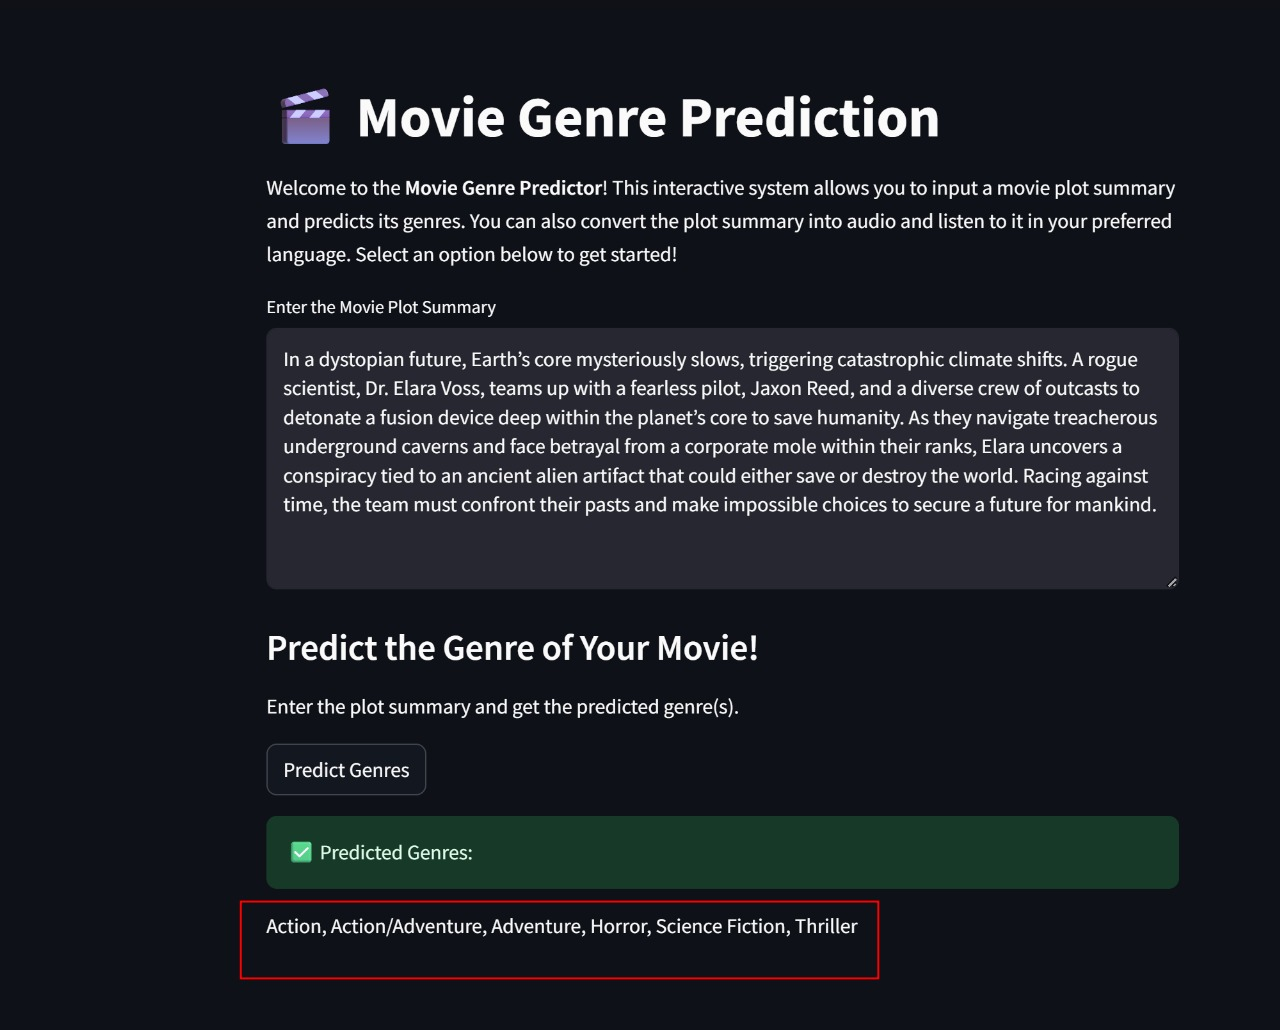

In [3]:
   from IPython.display import Image
   
   Image(r"C:\Users\cb26h\Desktop\final zip\2.jpg")


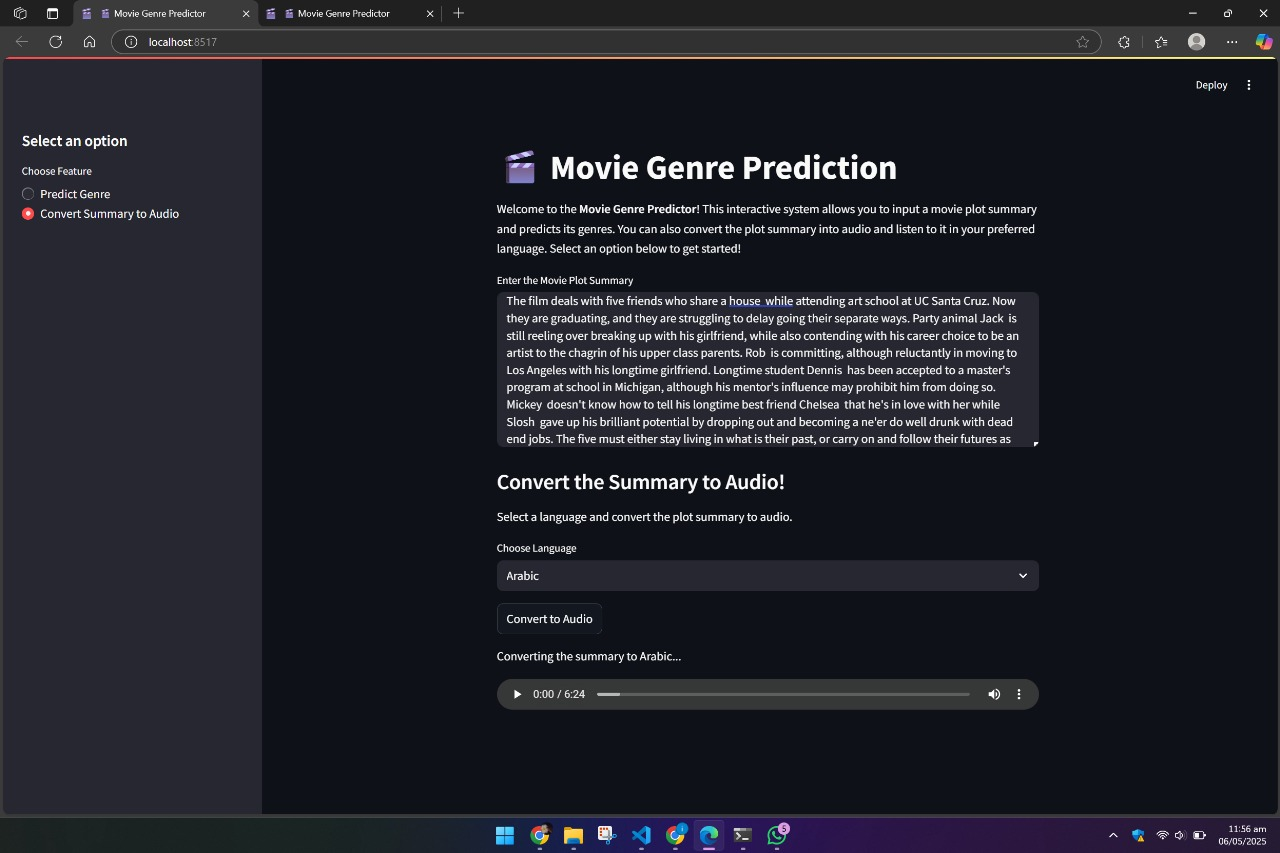

In [5]:
from IPython.display import Image
Image(r"C:\Users\cb26h\Desktop\final zip\1.jpg")